# BDA학회 데이터 분석 전처리 적용반 2주차 복습과제

제출자 성명: 이승섭89

2주차 코드를 재해석합니다.

Python 3.10.14 버전을 사용합니다.

## 0. Import Relevant Libraries
학습에 필요한 라이브러리를 불러옵니다.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Find Relevant Features
여러 독립변수 (feature)과 종속변수 (label)에서 종속변수에 영향을 많이 끼치는 독립변수를 추출합니다.

### 0. Prepare dataset

In [2]:
# Seed
np.random.seed(42)

# Data generation function
def generate_data(n_samples):
    X1 = np.random.rand(n_samples) * 100  # Strong correlation with y
    X2 = np.random.rand(n_samples) * 100  # Strong correlation with y
    X3 = np.random.rand(n_samples) * 100  # Weak correlation with y
    X4 = np.random.rand(n_samples) * 100  # No correlation with y
    X_noise = np.random.rand(n_samples) * 100  # Random noise
    y = 3 * X1 + 2 * X2**2 + np.random.randn(n_samples) * 10  # Target variable, influenced by X1 and X2 (and some noise)

    df = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X_noise': X_noise,
        'y': y
    })
    
    return df

# Create the initial dataset
df = generate_data(1000)

In [3]:
corr_matrix = df.corr()
print("Correlation matrix:\n", corr_matrix)

Correlation matrix:
                X1        X2        X3        X4   X_noise         y
X1       1.000000  0.029310  0.014518 -0.029424  0.034785  0.034323
X2       0.029310  1.000000  0.027262 -0.005791  0.032911  0.968180
X3       0.014518  0.027262  1.000000 -0.013560 -0.008858  0.029630
X4      -0.029424 -0.005791 -0.013560  1.000000 -0.044812 -0.014283
X_noise  0.034785  0.032911 -0.008858 -0.044812  1.000000  0.026530
y        0.034323  0.968180  0.029630 -0.014283  0.026530  1.000000


### 1. Filter features by correlation

In [4]:
threshold = 0.5
selected_features = corr_matrix['y'][abs(corr_matrix['y']) > threshold].index.drop('y')
print("\nSelected features:\n", selected_features)


Selected features:
 Index(['X2'], dtype='object')


### 2. Train Model On Features

In [5]:
# Train and evaluate model function
def evaluate_model(df, selected_features):

    X = df[selected_features]
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [6]:
# Selected features
mse_selected = evaluate_model(df, selected_features)
print("\nMSE with selected features:", mse_selected)

# All features
all_features = df.columns.drop('y')
mse_full = evaluate_model(df, all_features)
print("MSE with all features:", mse_full)


MSE with selected features: 2324571.2048381604
MSE with all features: 2339749.5902585215


## 2. Exclude Collinear Features
독립변수 (feature) 중 서로 상관계수가 높은 변수 중 하나를 제거합니다. 이를 통해 오차 편향을 줄일 수 있습니다.

### 0. Prepare dataset

In [7]:
# Data generation function
def generate_data_with_collinearity(n_samples):
    X1 = np.random.rand(n_samples) * 100
    X2 = X1 + np.random.rand(n_samples) * 10  # X1 and X2 highly collinear
    X3 = X1**np.random.rand(n_samples) * 100 # X1 and X3 non-linearly related
    X4 = np.random.rand(n_samples) * 100
    X_noise = np.random.rand(n_samples) * 100
    y = 3 * X1 + 2 * X3 + X4**2 + np.random.randn(n_samples) * 10
    
    df = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X_noise': X_noise,
        'y': y
    })
    
    return df

# Create the dataset with collinearity
df_collinear = generate_data_with_collinearity(1000)

In [8]:
corr_matrix_collinear = df_collinear.drop(columns=['y']).corr()
print("\nCorrelation matrix:\n", corr_matrix_collinear)


Correlation matrix:
                X1        X2        X3        X4   X_noise
X1       1.000000  0.995216  0.366946 -0.034015  0.053546
X2       0.995216  1.000000  0.358673 -0.036019  0.053226
X3       0.366946  0.358673  1.000000 -0.002443  0.026393
X4      -0.034015 -0.036019 -0.002443  1.000000 -0.045078
X_noise  0.053546  0.053226  0.026393 -0.045078  1.000000


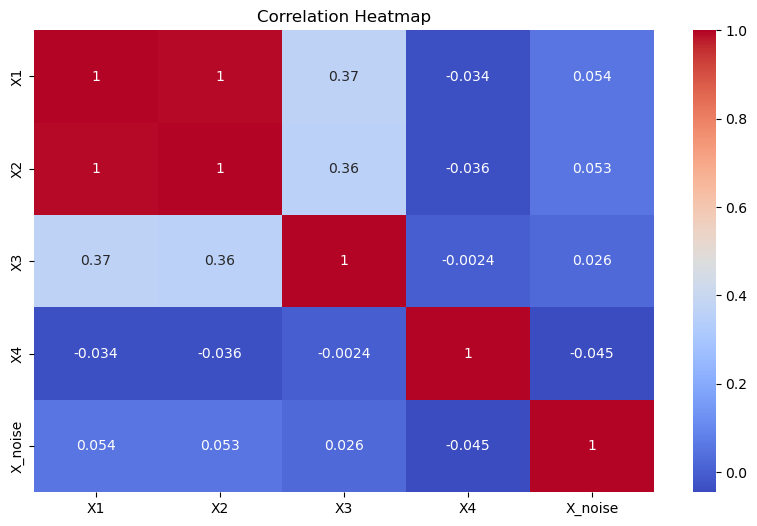

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_collinear, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

### 1. Filter Features by Collinearity

In [10]:
# Filter function
def drop_collinear_features(df, threshold=0.8):
    corr_matrix = df.corr()
    to_drop = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                to_drop.add(corr_matrix.columns[i])
    
    return df.drop(columns=list(to_drop))

df_reduced = drop_collinear_features(df_collinear.drop(columns=['y']))
print("\nReduced dataset columns:\n", df_reduced.columns)


Reduced dataset columns:
 Index(['X1', 'X3', 'X4', 'X_noise'], dtype='object')


### 2. Train Model on Features

In [11]:
# Reduced features
mse_reduced = evaluate_model(df_collinear, df_reduced.columns)
print("\nMSE with selected features:", mse_reduced)

# All features
mse_full_collinear = evaluate_model(df_collinear, df_collinear.columns.drop('y'))
print("MSE with all features:", mse_full_collinear)


MSE with selected features: 612991.800630083
MSE with all features: 614041.0790295362


In [ ]:
# Blank cell for running whole notebook.